# Generating Golf Clubs with StyleGAN2-ADA : I created the new golf driver design !

GAN consisted of 2 networks, the generator, and the discriminator. The generator will try to generate fake samples and fool the discriminator into believing it to be real samples. The discriminator will try to detect the generated samples from both the real and fake samples. This interesting adversarial concept was introduced by Ian Goodfellow in 2014

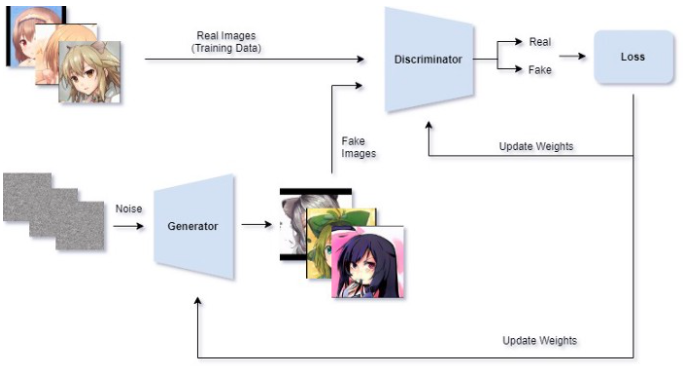

# 0. Colab problems

This notebook is set up to enable you to completely train your model for free using Google Colab. This approach does present some challenges. We review them here and offer a few tips to overcome each problem. If you are not training on Colab, you may skip this section.

**Problem: Colab offers maximum 1 GPU, which makes training StyleGAN very slow.**

There is no way to make Colab train faster, but you may reduce your total training time by using resuming from a pre-trained model or prior checkpoint and transfer learning (more on that later), as well as reducing the total compute needed by using a smaller architecture or resolution (e.g. 256x256 takes 16x less time to train as 1024x1024).

**Problem: Your file system in Colab is ephemeral, created on the spot, and deleted by Google after 12 hours of inactivity. It does not initially have any access to your dataset, and you are at risk of losing your training job.**

Because of the temporariness of the file system, it is best to load your dataset from and save your checkpoints to a location of persistent storage that Colab has access to. The easiest way to do this is by mounting your [Google Drive](https://drive.google.com/) to Colab and doing all of your i/o from there. This will be explained in the next cell.

**Problem: Colab is intended for interaction and tends to disconnect if you go idle for too long, interrupting long-running training jobs.**

As noted in the file system probem, the best solution for this is to save your checkpoints to Google Drive instead of to the Colab file system, and save them more frequently. Then you can babysit the job, restarting and resuming from the latest checkpoint each time you've noticed it gets disconnected.

### 1. Import the libraries that we need



Running import tensorflow will import the default version (currently 2.x). You can use 1.x by running a cell with the tensorflow_version magic (%) before you run import tensorflow.

In [1]:
##Make sure Tensorflow 1.15 is set
#Colab now defaults to Tensorflow 2. Make sure you run this cell to reset it to TF1.
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
#You can verify GPU is enabled by clicking Edit > Notebook Settings. Set the Hardware accelerator to GPU if it is not already.
#Nvidia’s GPU utilization summary :
!nvidia-smi

Fri Jan 21 10:00:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#GLOBAL VARIABLES
HEIGHT_PX = 512
WIDTH_PX = 512


### 2. Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Google Drive should appear in file index as "drive/".

### 3. Resizing and Uploading the Images

If you are using your own dataset, create a folder and put all training images inside a folder. Make sure all the images are square and the same size.

After scraping the images, they need to be **resized** because training StyleGAN2-ADA only works with image sizes 256 x 256, 512 x 512, or 1024 x 1024. 

I am going to train using the **512 x 512 model**, so I need to resize all the images to those dimensions.

Resizing the images is easy using Pillow, the Python Image Library (PIL). PIL includes powerful image processing capabilities, and it supports several file formats.

In [1]:
#import dependencies 
from PIL import Image
import os, sys
import shutil


In [6]:
#set file path
path = "/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/club/"
dirs = os.listdir(path)
path_resized_folder = "/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/dataset_resized/"    #New folder with resized images

def resize():
    
    if os.path.isdir(path_resized_folder): #if resized folder already exists (old computations) -> delete folder and create it
        #os.rmdir(path_resized_folder)
        shutil.rmtree(path_resized_folder)
        os.mkdir(path_resized_folder)
    else:   #if folder doesn't exist -> create
        os.mkdir(path_resized_folder)

    #loop through the images
    print("Nb images :", len(dirs))
    for index, item in enumerate(dirs):
        #print(item)
        #print(os.path.isfile(path+item))
        if os.path.isfile(path+item):   #check whether the specified path is an existing regular file or not
            im = Image.open(path+item)
            full_filename, extension_name = os.path.splitext(path+item)
            #print("full_filename :", full_filename)
            #print("extension_name :", extension_name)
            
            #set the output size: 256x256 or 512x512 or 1024x1024
            imResize = im.resize((WIDTH_PX,HEIGHT_PX), Image.ANTIALIAS)
            
            #save the images as image name + resized
            imResize.save(path_resized_folder + str(index) + ' _resized.jpg', 'JPEG', quality=100, optimize=True)

#run the funtion
resize()

Nb images : 304


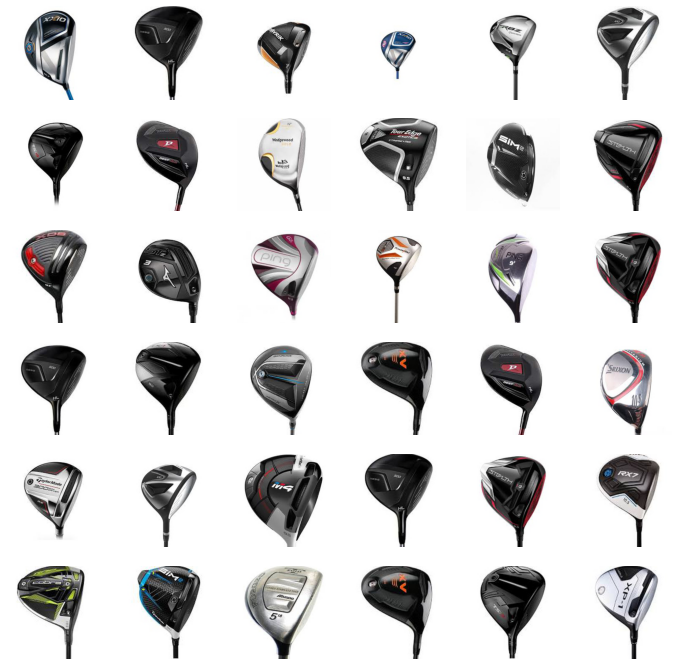

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# these two variables are "the parameters" of this cell
w = 6
h = 6

# this function uses the open, resize and array functions we have seen before
load_img = lambda filename: np.array(Image.open(f"/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/dataset_resized/{filename}"))
train = os.listdir("/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/dataset_resized/")
_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h)) # define a grid of (w, h)

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        img = np.random.choice(train) # take a random train filename (like 000c34352.jpg)
        ax.imshow(load_img(img)) # load and show


### 4. Installing the StyleGAN Repo on Drive

In [7]:
path = "/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/"
path_repo = "/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/colab-sg2-ada"

if os.path.isdir(path_repo):
    %cd "/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/colab-sg2-ada/stylegan2-ada"
    !git pull #Make sure to have the last version
else:
    #install script
    %cd "/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/"
    !mkdir colab-sg2-ada
    %cd colab-sg2-ada
    
    #clone of the official repo. 
    !git clone https://github.com/dvschultz/stylegan2-ada   #UNOFFICIAL REPO
    #!git clone https://github.com/NVlabs/stylegan2-ada      #OFFICIAL REPO
    %cd stylegan2-ada
    !mkdir downloads
    !mkdir datasets

/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation
/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/colab-sg2-ada
Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 364, done.
remote: Total 364 (delta 0), reused 0 (delta 0), pack-reused 364
Receiving objects: 100% (364/364), 56.16 MiB | 17.07 MiB/s, done.
Resolving deltas: 100% (200/200), done.
Checking out files: 100% (52/52), done.
/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/colab-sg2-ada/stylegan2-ada


### 5. Convert Images to TFRecords

StyleGAN2-ADA requires the data be in the TFRecord file format, Tensorflow’s unique Binary Storage Format. This means the images need to be converted to the .tfrecords format.

Converting the images can take a few minutes.

In [8]:
#Path to the image folder
dataset_path = path_resized_folder

#give your dataset a name
dataset_name = "dataset_clubs_" + str(WIDTH_PX) + "x" + str(HEIGHT_PX)

#full folder dataset path
dataset_folder_path = "./datasets/" + dataset_name

#delete old folder if already created
#print(dataset_folder_path)
#print(os.path.isdir(dataset_folder_path))
if os.path.isdir(dataset_folder_path):
  shutil.rmtree(dataset_folder_path)

#Do Not edit this
!python dataset_tool.py create_from_images ./datasets/{dataset_name} {dataset_path}     #add to dataset directory the .tfrecords

Loading images from "/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/dataset_resized/"
Creating dataset "./datasets/dataset_clubs_256x256"
dataset_tool.py:97: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
Added 304 images.


### 6. Training StyleGAN2-ADA

##Training
Note: this will require you to restart your Colab machine every 8–16 hours. You’ve been warned!

This library is set up to automatically find your latest .pkl file so it should keep re-training and making progress.

##Training Options

To see all possible options for training :

In [9]:
!python train.py --help

usage: train.py [-h] --outdir DIR [--gpus INT] [--snap INT] [--seed INT] [-n]
                --data PATH [--res INT] [--mirror BOOL] [--mirrory BOOL]
                [--use-raw BOOL] [--metrics LIST] [--metricdata PATH]
                [--cfg {auto,11gb-gpu,11gb-gpu-complex,24gb-gpu,24gb-gpu-complex,48gb-gpu,48gb-2gpu,stylegan2,paper256,paper512,paper1024,cifar,cifarbaseline,aydao}]
                [--lrate FLOAT] [--ttur BOOL] [--gamma FLOAT] [--nkimg INT]
                [--kimg INT] [--topk FLOAT] [--aug {noaug,ada,fixed,adarv}]
                [--p FLOAT] [--target TARGET] [--initstrength INITSTRENGTH]
                [--augpipe {blit,geom,color,filter,noise,cutout,bg,bgc,bgcf,bgcfn,bgcfnc}]
                [--cmethod {nocmethod,bcr,zcr,pagan,wgangp,auxrot,spectralnorm,shallowmap,adropout}]
                [--dcap FLOAT] [--resume RESUME] [--freezed INT]

Train a GAN using the techniques described in the paper
"Training Generative Adversarial Networks with Limited Data".

optional

`--dataset`

This should be the name you used in the first path when converting your dataset.

`--mirror-augment`

Using this option loads some images at random mirrored horizontally (left-to-right). This might help if you have a very small dataset.

`--metrics`

METRICS DON’T MATTER. It’s art! Use your eyes. Set `--metrics=None` and live your life.

If you must use metrics, you have a few options. `fid50k`, the default, uses Frechet Inception Distance score. It’s what was used in StyleGAN1 and what most people know. It’s fine for images of animals and things, but it’s not great. `ppl_wend` is what StyleGAN2 prefers and claims to be more accurate. There are a bunch of other options but I’d recommend you stick with those. Note that both of these take 30–45minutes to run every time it runs so that cuts into your training time in Colab.

`--snapshot_count`

snap is how often you want to save the model and sample results. Set the snapshot_count. Snapshots are like save points, so you don’t have to start from scratch when the training stops. They’re produced about every 20 minutes, but this number controls how many to save – e.g. a count of four will save one out of every four. Set it too low and you’ll completely fill up your Drive, set it too high and you’ll lose hours of training whenever Colab times out.

`--res`

res is what image resolution you want to train on

`--augpipe`

augpipe is augmentation pipes, such as 'blit', 'geom', 'color', 'filter', 'noise', 'cutout' or combination of these

`--results_dir`

output folder where to put checkpoints, will create the folder if it doesn't already exist (default 'results')

`--save_every`

how many ticks after which to save a checkpoint and preview images of the model. Default is 50, but if you are using Colab or some other environment where you might be interrupted often, can be useful to set it lower so as to avoid losing hours of training if you are disconnected.

`--dataset_root`

a relative or absolute path to the root of the dataset generated with the dataset tool.

`--mirror`

use horizontal flipping to augment the dataset during runtime, can be useful even alongside ADA augmentation (default `False`)

`--labels`

whether to train conditionally to labels or not. If set to `True`, the dataset must have a `dataset.json` file in its root with label assignments for all images, prepared by the dataset tool.

`--base_config`

select an architecture config from these options: 'auto', 'stylegan2', 'paper256', 'paper512', 'paper1024', 'cifar'.  'stylegan2' is the top quality preset but the slowest to train. If 'auto' is selected, StyleGAN2 will choose an architecture depending on dataset characteristics and number of GPUs available (default 'auto'),

`--kimg`

number of images to train on, effectively how long to train for, measured in 1000s of images (default 25000)

`--resume`

resume training from a previous checkpoint. If omitted or set to `None`, training begins on a from scratch. If set to `auto`, the trainer will automatically select the most recent checkpoint for the same dataset and specs if one is found. Otherwise, you can use one of NVIDIA's presets (including 'ffhq256', 'ffhq512', 'ffhq1024', 'celebahq256', 'lsundog256') or give it a relative/absolute path to a pkl file  (default `None`).

`--gpu`

a list of GPU indexes to use, e.g. [0, 1] to use your first two GPUs. If omitted or set to `None`, will automatically revert to using all available card.

Start training :

Additionally, you can also use this argument for **transfer learning**. Instead of training from scratch, it is usually best to start with one of the pre-trained models, even if the dataset itself not similar. Just replace the .pkl path with one of the pre-trained models provided by StyleGAN-ADA. Notice resume_from is set to **ffhq512** because this is the initial training.

The downside to using Colab is it will disconnect the runtime due to inactivity, and it has limited GPU usage. When Colab times out, resume the training by updating the resume_from value to the latest .pkl path.

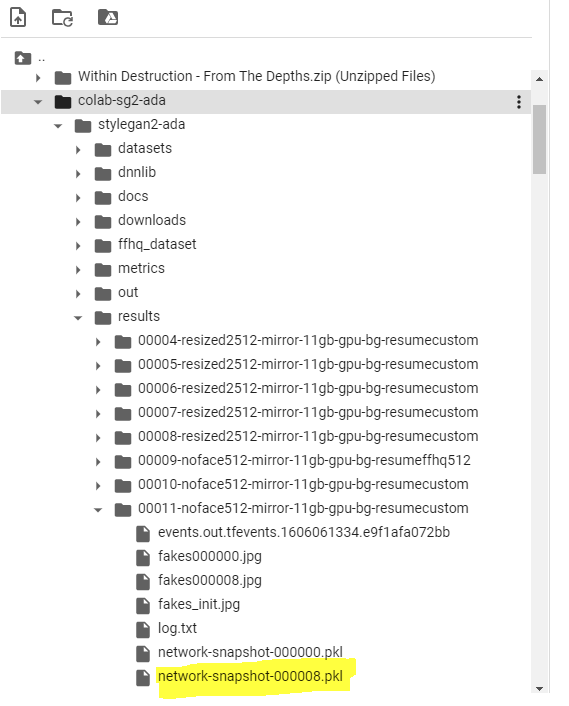

For example, if I want to resume training using network-snapshot-000008.pkl, I’d copy the path and paste it in place of ffhq512 for resume_from.



```
resume_from = "/content/drive/MyDrive/colab-sg2-ada/stylegan2-ada/results/00011-noface512-mirror-11gb-gpu-bg-resumecustom/network-snapshot-000008.pkl"
```


Once you run the command, it will start training and periodically save the result and the model file (.pkl) based on the snap arguments that you provided (In this case, every 4kimg). Once you think that the result is good enough or the FID starts to plateau, you can stop training and use the last saved .pkl file.

In [15]:
#Name of the dataset used when converting to tfrecords. 
dataset_name = "dataset_clubs_" + str(WIDTH_PX) + "x" + str(HEIGHT_PX)

#how often should the model generate samples and a .pkl file
snapshot_count = 10

#mirror images left to right?
mirrored = False

#mirror images top to bottom?
mirroredY = False

#metrics output (if True -> Can make the process take longer to complete)
metric_list = None

#augments
augs = "bgc"

#kimg
kimg = 1000

#To start transfer-learning, use ffhq+resulution value. 
#To resume training from your model, paste in path to .pkl file.
resume_from = 'ffhq512' #"/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/colab-sg2-ada/stylegan2-ada/results/00001-dataset_clubs_512x512-11gb-gpu-bg-resumeffhq512/network-snapshot-000000.pkl"

#Do Not edit the following unless you know what you're doing
!python train.py --outdir ./results --snap={snapshot_count} --cfg=11gb-gpu --data=./datasets/{dataset_name} --augpipe={augs} --mirror={mirrored} --mirrory={mirroredY} --metrics={metric_list} --resume={resume_from} --augpipe="bg"

tcmalloc: large alloc 4294967296 bytes == 0x55d019986000 @  0x7f2c2165f001 0x7f2c1e8451af 0x7f2c1e89bc23 0x7f2c1e89ca87 0x7f2c1e93e823 0x55d0133af46c 0x55d0133af240 0x55d013423627 0x55d01341dced 0x55d0133b148c 0x55d0133f2159 0x55d0133ef0a4 0x55d0133afd49 0x55d01342394f 0x55d01341d9ee 0x55d0132efe2b 0x55d01341ffe4 0x55d01341d9ee 0x55d0132efe2b 0x55d01341ffe4 0x55d01341dced 0x55d0132efe2b 0x55d01341ffe4 0x55d0133b0afa 0x55d01341e915 0x55d01341d9ee 0x55d01341d6f3 0x55d0134e74c2 0x55d0134e783d 0x55d0134e76e6 0x55d0134bf163
tcmalloc: large alloc 4294967296 bytes == 0x55d119986000 @  0x7f2c2165d1e7 0x7f2c1e8450ce 0x7f2c1e89bcf5 0x7f2c1e89bf4f 0x7f2c1e93e673 0x55d0133af46c 0x55d0133af240 0x55d013423627 0x55d01341d9ee 0x55d0133b0bda 0x55d01341f737 0x55d01341d9ee 0x55d0133b0bda 0x55d01341f737 0x55d01341d9ee 0x55d0133b0bda 0x55d01341f737 0x55d0133b0afa 0x55d01341e915 0x55d01341d9ee 0x55d0133b0bda 0x55d013422d00 0x55d01341d9ee 0x55d0133b0bda 0x55d01341f737 0x55d01341dced 0x55d0133b148c 0x55d0133f

*Note : Sometimes I had this error **"NotImplementedError: Cannot convert a symbolic Tensor (Train_gpu0/Loss_R1/gradients/Train_gpu0/Augment_1/transform/ImageProjectiveTransformV2_grad/flat_transforms_to_matrices/strided_slice:0) to a numpy array."** and I don't know why... The only solution I found to continue training is to create a new Colab with same lines of code.*

### 7. Testing the model (Generate images)

While the model is training, every so often it hits a checkpoint and outputs a .jpg file along with the .pkl file. The .jpg **shows the progress of the transformation from faces to training data**. Even by the 8th iteration in the first training runtime, the faces have significantly changed.

Here we choose transfer learning weights from pre-trained StyleGAN2 Face Recognition model. That's why we always start from fake face images as purpose of the discriminator. 

If we'd chosen to trained the StyleGAN2 model from scratch, we would have noise images instead of faces at the beginning of the training. 

The Generator goal is to generate fakes images (Clubs here).

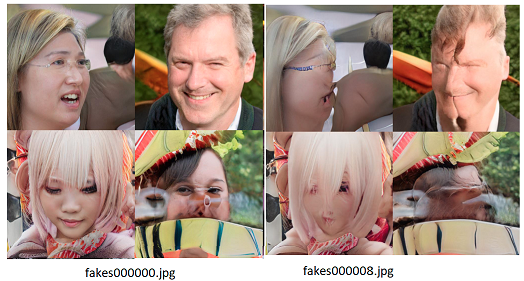

When the fake images begin to look like the real images, it is time to start exploring the custom model.

We need to install a library before generating images :

In [11]:
!pip install opensimplex

Generate images in the command line by running generate.py along with parameters for the image seeds and .pkl path.

The following command will generate 55 sample images from the model.


#### Options
`--network`

Make sure the `--network` argument points to your .pkl file. (My preferred method is to right click on the file in the Files pane to your left and choose `Copy Path`, then paste that into the argument after the `=` sign).

`--seeds`

The seeds produce vectors of appropriate length behind the scenes, which are used to produce the image from the model. This allows you to choose random seeds from the model. Remember that our input to StyleGAN is a 512-dimensional array. These seeds will generate those 512 values. Each seed will generate a different, random array. The same seed value will also always generate the same random array, so we can later use it for other purposes like interpolation.

`--truncation-psi`

Truncation is a special argument of StyleGAN. Essentially values that are closer to 0 will be more real than numbers further away from 0. I generally recommend a value between `0.5` and `1.0`. `0.5` will give you pretty "realistic" results, while `1.0` is likely to give you "weirder" results.

In [12]:
!python generate.py generate-images --trunc=1 --seeds=85,265,297,849 --network="results/00001-dataset_clubs_512x512-11gb-gpu-bg-resumeffhq512/network-snapshot-000000.pkl"

#Generating 55 images
#!python run_generator.py generate-images --network=/content/ladiesfloralcrop-network-snapshot-010237.pkl --seeds=3875451-3876000 --truncation-psi=0.7

Loading networks from "results/00001-dataset_clubs_512x512-11gb-gpu-bg-resumeffhq512/network-snapshot-000000.pkl"...
Traceback (most recent call last):
  File "generate.py", line 814, in <module>
    main()
  File "generate.py", line 809, in main
    func(**kwargs)
  File "generate.py", line 68, in generate_images
    with dnnlib.util.open_url(network_pkl) as fp:
  File "/content/drive/MyDrive/FORMATION/DEEP_LEARNING/StyleGAN_Driver_Generation/colab-sg2-ada/stylegan2-ada/dnnlib/util.py", line 386, in open_url
    return url if return_filename else open(url, "rb")
FileNotFoundError: [Errno 2] No such file or directory: 'results/00001-dataset_clubs_512x512-11gb-gpu-bg-resumeffhq512/network-snapshot-000000.pkl'


You can provide a range or a comma-separated value for the seeds. 

The trunc is the value for the truncation trick. The higher the truncation value the more diverse or extreme the output, but might lower the image quality. The lower the value, the higher the image quality but might be less diverse. The maximum value is 1.

The images will appear in Drive in the out folder.

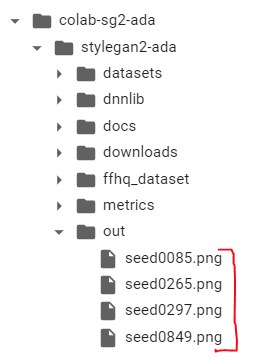

### 8.Interpolation (Latent Walk)


In [12]:
!python run_generator.py generate-latent-walk --network=/content/ladiesfloralcrop-network-snapshot-010237.pkl --seeds=3,11,17,25,3 --frames 200 --truncation-psi=0.7

In [ ]:
#convert to video 
!ffmpeg -r 24 -i ./results/00001-generate-latent-walk/step%05d.png -vcodec libx264 -pix_fmt yuv420p latent-walk-v2.mp4

### Articles: 

* https://colab.research.google.com/github/dvschultz/ai/blob/master/StyleGAN2_Colab_Train.ipynb#scrollTo=BTwJjmCrlfAc (explained colab)
* https://github.com/tanguyesteoule/thisalbumdoesnotexist
* https://towardsdatascience.com/stylegan-v2-notes-on-training-and-latent-space-exploration-e51cf96584b3
*   https://towardsdatascience.com/how-to-train-stylegan2-ada-with-custom-dataset-dc268ff70544
*   https://medium.com/codex/how-to-train-stylegan2-ada-in-colab-using-instagram-images-7ff552667a20





